In [53]:
!pip install beautifulsoup4

In [54]:
import pandas as pd
import numpy as np
from plotnine import *
import re
import requests
from bs4 import BeautifulSoup

In [5]:
pd.set_option("display.max_columns", None)
NationalParksData = pd.read_csv("national_park_trails.csv")
#making it tidy
#Splitting latitude and longitude
NationalParksData[['latitude', 'longitude']] = NationalParksData['_geoloc'].str.split(', ', expand=True)
NationalParksData['latitude'] = NationalParksData['latitude'].str.split(': ').str.get(1)
NationalParksData['longitude'] = NationalParksData['longitude'].str.split(': ').str.get(1)
NationalParksData['longitude'] = NationalParksData['longitude'].str.replace("}", "")

#Splitting features and activitvities into dummy variables
NationalParksData['features'] = NationalParksData['features'].apply(lambda x: x.replace("'", ""))
NationalParksData['features'] = NationalParksData['features'].apply(lambda x: x.replace("[", ""))
NationalParksData['features'] = NationalParksData['features'].apply(lambda x: x.replace("]", ""))
NationalParksData['features'] = NationalParksData['features'].apply(lambda x: x.replace(" ", ""))

NationalParksData['features'] = NationalParksData['features'].apply(lambda x: x.split(","))

NationalParksData = NationalParksData.explode('features')

FeaturesDummies = pd.get_dummies(NationalParksData['features'], prefix= 'features', prefix_sep='_')

NationalParksData = pd.concat([NationalParksData, FeaturesDummies], axis = 1)

FeaturesList = list(NationalParksData.columns[18:])
RegularList = list(NationalParksData.columns[1:18])

FeaturesHalf = NationalParksData.groupby('trail_id')[FeaturesList].sum().reset_index()
RegularHalf = NationalParksData.groupby('trail_id')[RegularList].first().reset_index()

NationalParksData = pd.merge(RegularHalf, FeaturesHalf, on = 'trail_id')

# for activities
NationalParksData['activities'] = NationalParksData['activities'].apply(lambda x: x.replace("'", ""))
NationalParksData['activities'] = NationalParksData['activities'].apply(lambda x: x.replace("[", ""))
NationalParksData['activities'] = NationalParksData['activities'].apply(lambda x: x.replace("]", ""))
NationalParksData['activities'] = NationalParksData['activities'].apply(lambda x: x.replace(" ", ""))

NationalParksData['activities'] = NationalParksData['activities'].apply(lambda x: x.split(","))

NationalParksData = NationalParksData.explode('activities')

ActivitiesDummies = pd.get_dummies(NationalParksData['activities'], prefix= 'activities', prefix_sep='_')

NationalParksData = pd.concat([NationalParksData, ActivitiesDummies], axis = 1)

RegularList = list(NationalParksData.columns[1:40])
ActivitiesList = list(NationalParksData.columns[40:])

ActivitiesHalf = NationalParksData.groupby('trail_id')[ActivitiesList].sum().reset_index()
RegularHalf = NationalParksData.groupby('trail_id')[RegularList].first().reset_index()

NationalParksData = pd.merge(RegularHalf, ActivitiesHalf, on = 'trail_id')

#if nan from visitor usage need to be removed
NationalParksDataNoNa = NationalParksData.dropna(subset=['visitor_usage'])

<ipython-input-5-a20fca6f5bdf>:8: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
<ipython-input-5-a20fca6f5bdf>:27: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


,trail_id,name,area_name,city_name,state_name,country_name,_geoloc,popularity,length,elevation_gain,difficulty_rating,route_type,visitor_usage,avg_rating,num_reviews,features,activities,units,features_,features_ada,features_beach,features_cave,features_city-walk,features_dogs,features_dogs-leash,features_dogs-no,features_forest,features_historic-site,features_hot-springs,features_kids,features_lake,features_partially-paved,features_paved,features_rails-trails,features_river,features_strollers,features_views,features_waterfall,features_wild-flowers,features_wildlife,activities_backpacking,activities_bike-touring,activities_birding,activities_camping,activities_canoeing,activities_cross-country-skiing,activities_fishing,activities_fly-fishing,activities_hiking,activities_horseback-riding,activities_ice-climbing,activities_mountain-biking,activities_nature-trips,activities_off-road-driving,activities_paddle-sports,activities_rails-trails,activities_road-biking,activities_rock-climbing,activities_scenic-driving,activities_sea-kayaking,activities_skiing,activities_snowboarding,activities_snowshoeing,activities_surfing,activities_trail-running,activities_walking,activities_whitewater-kayaking
0,10000013,McKittrick Canyon Trail,Guadalupe Mountains National Park,Salt Flat,Texas,United States,"{'lat': 31.97778, 'lng': -104.75232}",11.5435,32508.668,1330.7568,3,out and back,2.0,4.5,64,dogs-no,camping,i,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
1,10000030,Dorr Mountain Ladder Trail,Acadia National Park,Bar Harbor,Maine,United States,"{'lat': 44.35175, 'lng': -68.20508}",17.7959,4345.218,344.7288,5,loop,3.0,4.5,152,dogs-no,hiking,i,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,10000049,Rendezvous Mountain Trail,Grand Teton National Park,Wilson,Wyoming,United States,"{'lat': 43.59695, 'lng': -110.87107}",4.6573,11104.446,608.9904,5,out and back,2.0,4.5,10,forest,hiking,i,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,10000054,Sourdough Ridge Nature Trail,Mount Rainier National Park,Ashford,Washington,United States,"{'lat': 46.91467, 'lng': -121.64085}",15.5555,6276.426,215.7984,1,out and back,2.0,4.5,67,dogs-no,birding,i,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,1,1,0,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0
4,10000147,Boston Run Trail,Cuyahoga Valley National Park,Peninsula,Ohio,United States,"{'lat': 41.23206, 'lng': -81.50731}",10.5799,4988.954,70.7136,3,loop,3.0,4.0,134,dogs-leash,birding,i,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3308,10541288,Hoh River Trail to Mineral Creek Falls,Olympic National Park,Forks,Washington,United States,"{'lat': 47.8601, 'lng': -123.93447}",0.0000,8851.370,64.9224,1,out and back,3.0,4.5,75,dogs-no,hiking,i,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3309,10541335,Bridalveil Creek Campground to Ostrander Lake ...,Yosemite National Park,Yosemite Valley,California,United States,"{'lat': 37.66364, 'lng': -119.62455}",0.1941,34761.744,1123.7976,3,loop,1.0,0.0,0,forest,backpacking,i,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3310,10542445,Overall Run and Beecher Ridge Trail,Shenandoah National Park,Luray,Virginia,United States,"{'lat': 38.73929, 'lng': -78.30763}",0.0000,21726.090,965.9112,5,loop,2.0,4.5,8,dogs-leash,backpacking,i,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3311,10545116,Tenaya Lake to Half Dome Loop,Yosemite National Park,Yosemite Valley,Cal

In [3]:
NationalParksDataTidy = NationalParksData.drop(columns = ['_geoloc', 'features', 'activities', 'features_'])

#natparksdatatidy
#'' nona
#'' regular


## **Question 1**

In [17]:
# length in miles for 4 longest trial in california

q1df = NationalParksData[NationalParksData['state_name'] == 'California']

q1df = q1df.sort_values(by= 'length', ascending = False).head(4)

# 1 meter = 0.000621371 miles

q1df['length'] = q1df['length'] * 0.000621371

q1df

,trail_id,name,area_name,city_name,state_name,country_name,_geoloc,popularity,length,elevation_gain,difficulty_rating,route_type,visitor_usage,avg_rating,num_reviews,features,activities,units,features_,features_ada,features_beach,features_cave,features_city-walk,features_dogs,features_dogs-leash,features_dogs-no,features_forest,features_historic-site,features_hot-springs,features_kids,features_lake,features_partially-paved,features_paved,features_rails-trails,features_river,features_strollers,features_views,features_waterfall,features_wild-flowers,features_wildlife,activities_backpacking,activities_bike-touring,activities_birding,activities_camping,activities_canoeing,activities_cross-country-skiing,activities_fishing,activities_fly-fishing,activities_hiking,activities_horseback-riding,activities_ice-climbing,activities_mountain-biking,activities_nature-trips,activities_off-road-driving,activities_paddle-sports,activities_rails-trails,activities_road-biking,activities_rock-climbing,activities_scenic-driving,activities_sea-kayaking,activities_skiing,activities_snowboarding,activities_snowshoeing,activities_surfing,activities_trail-running,activities_walking,activities_whitewater-kayaking
3264,10501331,John Muir Trail,Yosemite National Park,Lone Pine,California,United States,"{'lat': 36.58686, 'lng': -118.24013}",0.9673,210.999410,13165.8360,3,point to point,NaN,0.0,0,forest,backpacking,i,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,1,1,1,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0
168,10004781,John Muir Trail via Yosemite Valley,Yosemite National Park,Yosemite Valley,California,United States,"{'lat': 37.73476, 'lng': -119.56629}",24.0723,203.099432,14029.9440,5,point to point,3.0,4.5,129,dogs-no,backpacking,i,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,1,0,1,1,1,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2234,10270059,Ridgecrest to Death Valley OHV Trail,Death Valley National Park,Ridgecrest,California,United States,"{'lat': 35.61407, 'lng': -117.67073}",3.6185,165.899536,3045.8664,3,point to point,2.0,4.5,4,dogs-no,nature-trips,i,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
3129,10418330,Big SEKI Loop,Kings Canyon National Park,Hume,California,United States,"{'lat': 36.79608, 'lng': -118.58322}",2.1531,145.199594,10944.7584,7,loop,1.0,5.0,2,forest,backpacking,i,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,1,0,1,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## **Question 2**

Consider an “easy” trail to be one that has an elevation gain of less than 500 meters, a distance of less than 5 kilometers, and a difficulty rating below 4.

Which California National Park has the highest average rating of its “easy” trails?

In [20]:
q2df = NationalParksData[(NationalParksData['elevation_gain'] < 500) & (NationalParksData['length'] < 5000) & (NationalParksData['difficulty_rating'] < 4) & (NationalParksData['state_name'] == 'California')]

q2df[['area_name', 'avg_rating']].groupby('area_name').mean().sort_values(by= 'avg_rating', ascending = False)

,avg_rating
area_name,
Kings Canyon National Park,4.444444
Yosemite National Park,4.403226
Sequoia National Park,4.388889
Pinnacles National Park,4.250000
Lassen Volcanic National Park,4.131579
Joshua Tree National Park,3.857143
Death Valley National Park,3.711538
Redwood National Park,3.642857
Channel Islands National Park,3.375000


# **Question 3**

How many National Parks contain the word “Land” somewhere in their name? (if the word appears as part of a longer word, like “Candyland”, this counts too)

In [25]:
park_names = "|".join(NationalParksData['area_name'])

land_tag = re.findall(r"[^|]*[Ll]and[^|]*", park_names)

len(NationalParksData[NationalParksData['area_name'].isin(land_tag)])

109

# **Question 4**

Consider the following plot, made from a dataset called np_trails_new. Although you can see the code that made the plot, you do not see the code that made the np_trails_new object.

Your job in this question is to create the np_trails_new object. You’ll know when you have succeeded, because the code provided will produce the plot.

In Canvas, turn in the values of the first row of the np_trails_new object.

(If your dataset has more columns than seem to be available, only include the ones that were absolutely necessary to keep in this analysis.)

In [ ]:
# would have to change the dataframe measure would contain the 4 paramenters used by the 4 graphs, score would be the value of that

In [ ]:
from plotnine import ggplot, aes, geom_density, facet_wrap, ggtitle

(ggplot(np_trails_new, aes(x="score"))
+ geom_density()
+ facet_wrap('~ measure', scales = 'free')
+ ggtitle("Overall distribution of various trail scores in National parks")
)

# **Question 5**

In [34]:
ca_parks = NationalParksData[(NationalParksData['state_name'] == 'California')]

ca_parks = ca_parks[['area_name', 'num_reviews']]

/usr/local/lib/python3.10/dist-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log10
/usr/local/lib/python3.10/dist-packages/plotnine/layer.py:284: PlotnineWarning: stat_boxplot : Removed 54 rows containing non-finite values.


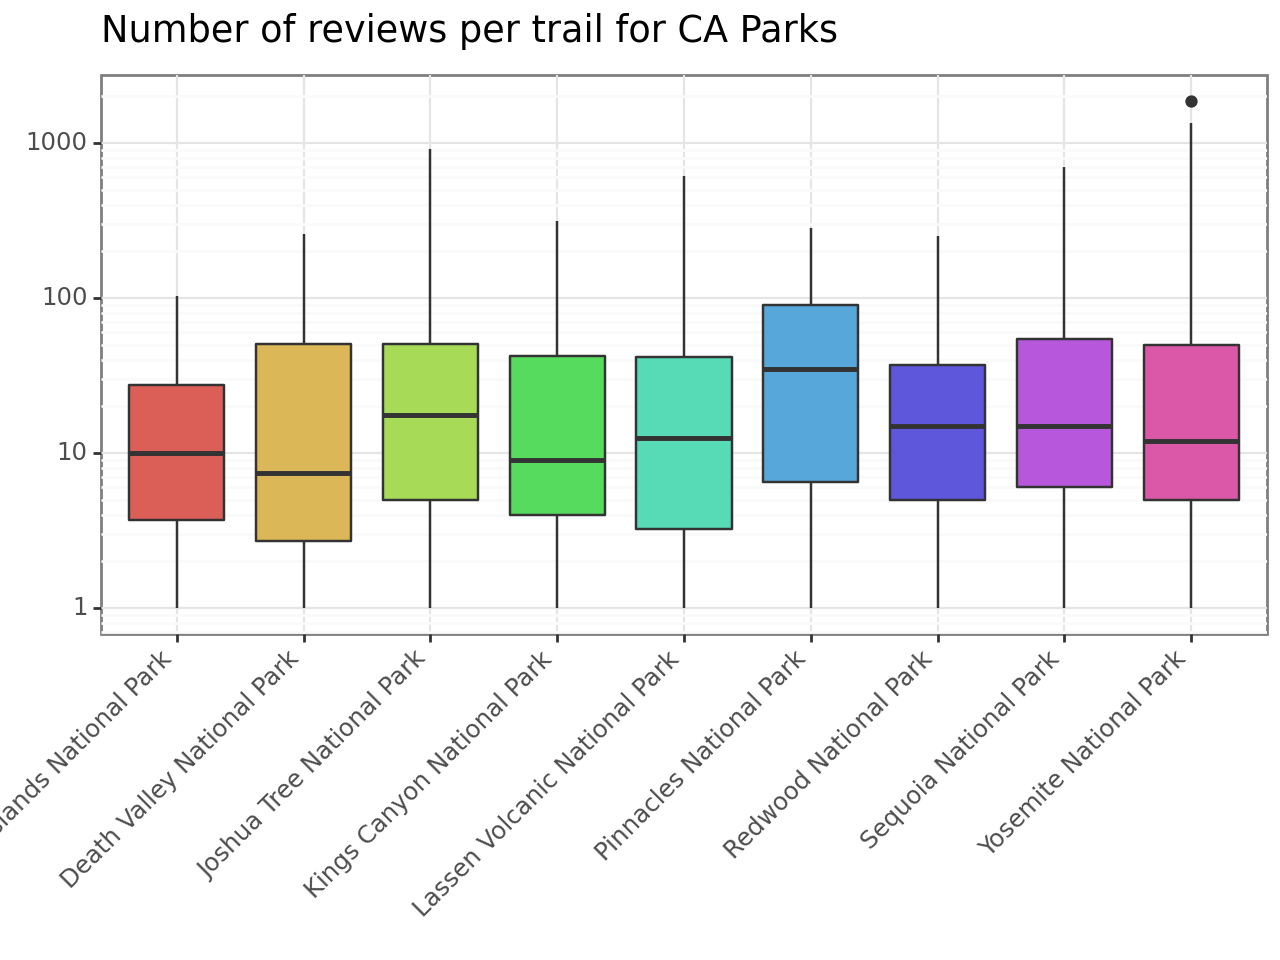

<Figure Size: (640 x 480)>

In [40]:
ca_parks = NationalParksData[(NationalParksData['state_name'] == 'California')]


from plotnine import ggplot, geom_boxplot, theme, labs, theme_bw
from plotnine.scales import scale_y_log10, scale_fill_discrete

(ggplot(ca_parks, aes(x="area_name", y="num_reviews", fill = "area_name"))
+ geom_boxplot()
+ scale_y_log10()
+ scale_fill_discrete(guide=False)
+ labs(
  x = "",
  y = "",
  title = "Number of reviews per trail for CA Parks"
)
+ theme_bw()
+ theme(axis_text_x=element_text(rotation=45, hjust=1))
)


# **Part 2**

In [57]:
def recommend_trails(dataset, nat_park_name, min_elev = None, max_elev = None, min_rate = None, trail_type = None):

  if min_elev is None:
    min_elev = 0
  else:
    min_elev = min_elev

  if max_elev is None:
    max_elev = 10000000
  else:
    max_elev = max_elev

  if min_rate is None:
    min_rate = 0
  else:
    min_rate = min_rate

  if trail_type is None:
    trail_type = ['point to point', 'loop', 'out and back']
  else:
    trail_type = trail_type

  trails = NationalParksData[(NationalParksData['area_name'] == nat_park_name) & (NationalParksData['elevation_gain'] >= min_elev) & (NationalParksData['elevation_gain'] <= max_elev) & (NationalParksData['avg_rating'] >= min_rate) & (NationalParksData['route_type'].isin(trail_type))]
  trails = trails['name']



  return trails

In [58]:
recommend_trails(NationalParksData, "Haleakala National Park", min_elev = 1000, min_rate = 4)

293     Silversword Loop Via Halemau'u Trail
527                              Kaupo Trail
1582                     Keonehe'ehe'e Trail
Name: name, dtype: object

## Question 2

In [ ]:

def scrape_temps(month = None):

  my_url = "https://www.extremeweatherwatch.com/us-state-averages"
  response = requests.get(my_url)
  soup = BeautifulSoup(response.content, "html.parser")
  results = soup.find_all("table")

  rows = []

  for result in results.find_all("tr")[1:]:
    cells = result.find_all("td")

    state_tag = cells[0].find("a") or cells[0]
    state = state_tag.get_text()

    company_tag = cells[1].find("td") or cells[1]
    companies = company_tag.get_text(strip = True)

    rows.append({
            "Statet": state,
            "Company Count": companies
            })

  climate = pd.DataFrame(rows)
  climate


  ## More of your code here


  return ______

In [68]:
my_url = "https://www.extremeweatherwatch.com/us-state-averages"
response = requests.get(my_url)
soup = BeautifulSoup(response.content, "html.parser")

table = soup.find("table", class_='bordered-table sort-table')

rows = []

for result in table.find_all("tr")[1:]:
    cells = result.find_all("td")

    state_tag = cells[0].find("a") or cells[0]
    state = state_tag.get_text()

    high_tag = cells[1]
    high = high_tag.get_text()

    low_tag = cells[2]
    low = low_tag.get_text()

    prec_tag = cells[3]
    prec = prec_tag.get_text()

    rows.append({
         "State": state,
         "High Temp": high,
         "Low Temp": low,
         "Preciptation": prec

    })

climate = pd.DataFrame(rows)
climate


,State,High Temp,Low Temp,Preciptation
0,Alabama,75.0,52.2,56.9
1,Alaska,35.5,20.4,37.6
2,Arizona,75.3,46.8,11.6
3,Arkansas,71.8,50.2,52.5
4,California,71.5,46.5,22.3
5,Colorado,60.0,32.4,18.0
6,Connecticut,60.0,39.8,48.7
7,Delaware,66.1,46.3,45.9
8,Florida,81.9,60.9,54.4
9,Georgia,75.6,52.7,50.4


In [72]:
## would have to go into the html file and go to a certain month here and do a if statement to change the url based on the question, but didnt have time:
#Averages by month:
#<a href='/us-state-averages/month-january'>January</a> |
#<a href='/us-state-averages/month-february'>February</a> |
#<a href='/us-state-averages/month-march'>March</a> |
#<a href='/us-state-averages/month-april'>April</a> |
#<a href='/us-state-averages/month-may'>May</a> |
#<a href='/us-state-averages/month-june'>June</a> |
#<a href='/us-state-averages/month-july'>July</a> |
#<a href='/us-state-averages/month-august'>August</a> |
#<a href='/us-state-averages/month-september'>September</a> |
#<a href='/us-state-averages/month-october'>October</a> |
#<a href='/us-state-averages/month-november'>November</a> |
#<a href='/us-state-averages/month-december'>December</a> |
#<a href='/us-state-averages'>Year</a>
#</div>

def scrape_temps(month = None):

  my_url = "https://www.extremeweatherwatch.com/us-state-averages"
  response = requests.get(my_url)
  soup = BeautifulSoup(response.content, "html.parser")

  table = soup.find("table", class_='bordered-table sort-table')

  rows = []

  for result in table.find_all("tr")[1:]:
      cells = result.find_all("td")

      state_tag = cells[0].find("a") or cells[0]
      state = state_tag.get_text()

      high_tag = cells[1]
      high = high_tag.get_text()

      low_tag = cells[2]
      low = low_tag.get_text()

      prec_tag = cells[3]
      prec = prec_tag.get_text()

      rows.append({
           "State": state,
           "High Temp": high,
           "Low Temp": low,
           "Preciptation": prec

      })

  climate = pd.DataFrame(rows)

  return climate

NameError: ignored

# **q3**

In [ ]:
recommend_trails(NationalParksData, nat_park_name, min_elev = 1000, max_elev = 3000, min_rate = 4.5, trail_type = 'loop')